# 入力画像の重みの可視化

In [1]:
# インポートをここのセルにまとめる
import yaml
import os
import shutil
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
from PIL import Image

from src.models import CAE

In [2]:
def calculate_psnr(img1, img2, max_val=1.0):
    """
    PSNRを計算
    Args:
        img1, img2: torch.Tensor (C, H, W) or (B, C, H, W)
        max_val: 画像の最大値 (通常は1.0)
    """
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    psnr = 20 * torch.log10(torch.tensor(max_val) / torch.sqrt(mse))
    return psnr.item()

In [3]:
# 設定ファイルとチェックポイントパスを指定
root_restult_dir = Path('/workspace/result')
ex_name = 'grayscale_autoencoder_v2_MSELoss_100'
config_path = root_restult_dir / ex_name / 'config.yaml'
checkpoint_path = root_restult_dir / ex_name / 'ckpts/cae_best.pth'

# 設定ファイルを読み込み
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# モデルを初期化
model = CAE(config)

# チェックポイントを読み込み
if Path(checkpoint_path).exists():
    model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
    print(f"✓ Loaded checkpoint from: {checkpoint_path}")
else:
    print(f"✗ Checkpoint not found: {checkpoint_path}")

model.eval()
print(f"✓ Model loaded successfully")

✓ Loaded checkpoint from: /workspace/result/grayscale_autoencoder_v2_MSELoss_100/ckpts/cae_best.pth
✓ Model loaded successfully


In [4]:
root_dataset_path = Path('/workspace/dataset')
dataset_name = "hpatches-sequences-release"
sean_name = "i_ajuntament"
image_name = "1.ppm"

image_path = root_dataset_path/dataset_name/sean_name/image_name

torch.Size([1, 480, 640])


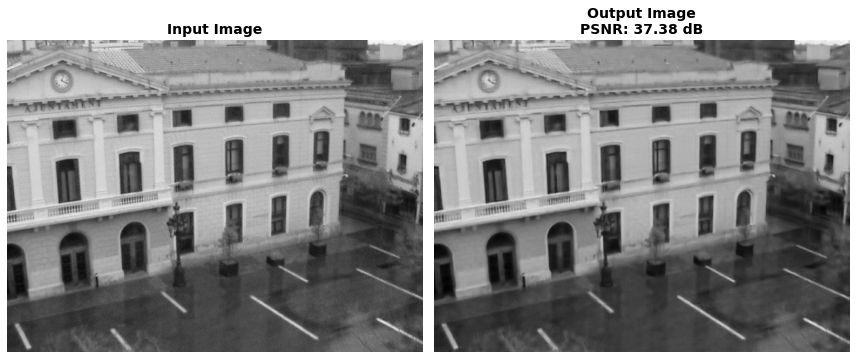

Image Shape: torch.Size([1, 1, 480, 640])
Output Shape: torch.Size([1, 1, 480, 640])
PSNR: 37.3817 dB


In [5]:


# Load image
image = Image.open(image_path)

# Convert to grayscale if config specifies 1 channel
if config["dataset"]['channels'] == 1:
    image = image.convert('L')  # Grayscale

# Convert to tensor and normalize
image_tensor = transforms.ToTensor()(image)
print(image_tensor.shape)  # Check shape

# Add batch dimension
image_tensor = image_tensor.unsqueeze(0)

# Inference
with torch.no_grad():
    output = model(image_tensor)

# PSNRを計算
psnr_value = calculate_psnr(image_tensor, output)

# 画像を表示用に変換
input_img = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
output_img = output.squeeze(0).permute(1, 2, 0).cpu().numpy()

# グレースケールの場合は最後の次元を削除
if input_img.shape[-1] == 1:
    input_img = input_img.squeeze(-1)
    output_img = output_img.squeeze(-1)
    cmap = 'gray'
else:
    cmap = None

# 横に並べて表示
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(input_img, cmap=cmap)
axes[0].set_title('Input Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(output_img, cmap=cmap)
axes[1].set_title(f'Output Image\nPSNR: {psnr_value:.2f} dB', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Image Shape: {image_tensor.shape}")
print(f"Output Shape: {output.shape}")
print(f"PSNR: {psnr_value:.4f} dB")


ENCODER CONV OUTPUTS


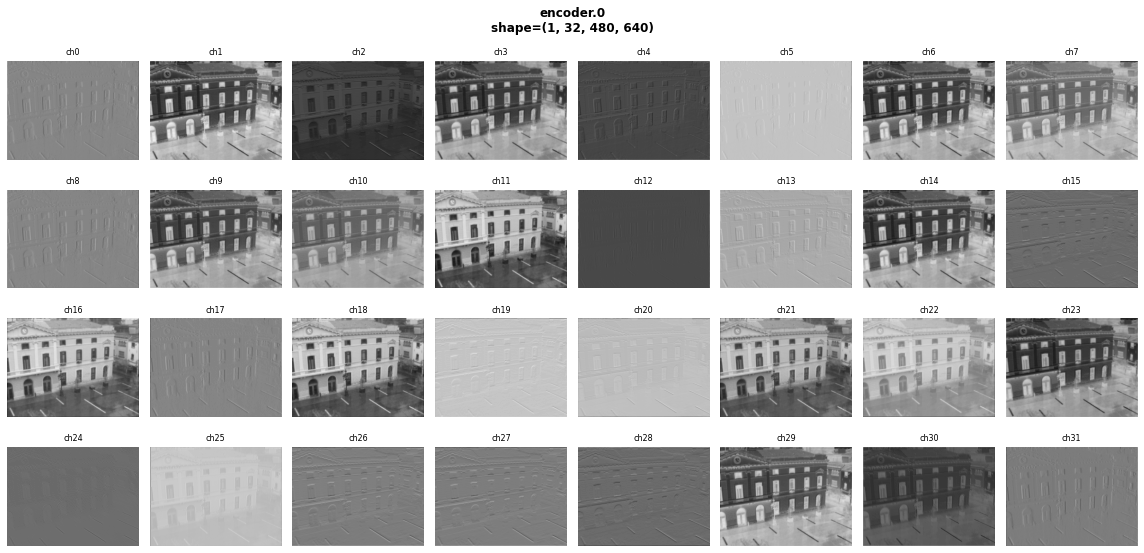

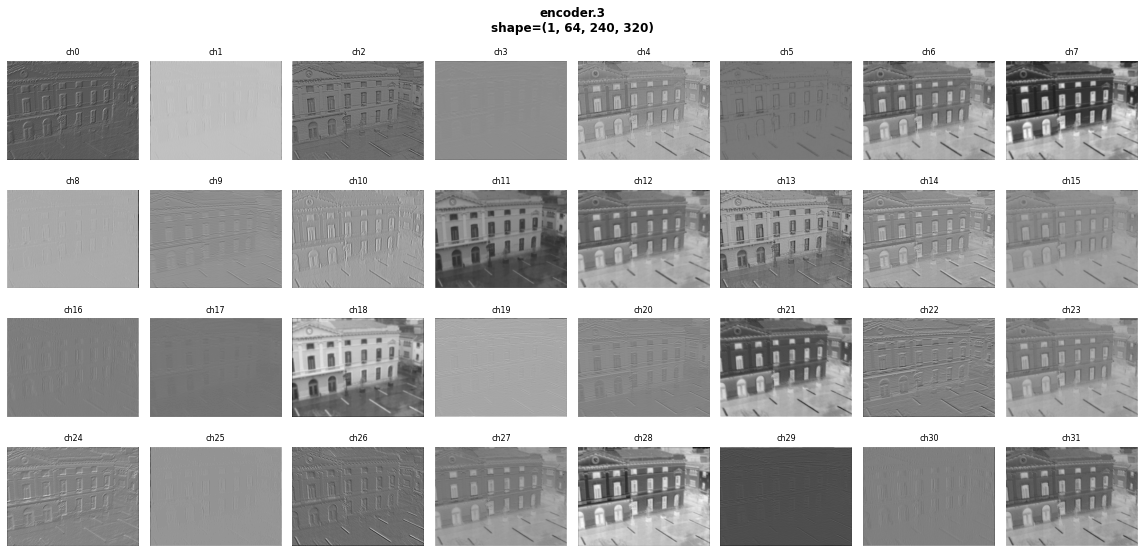

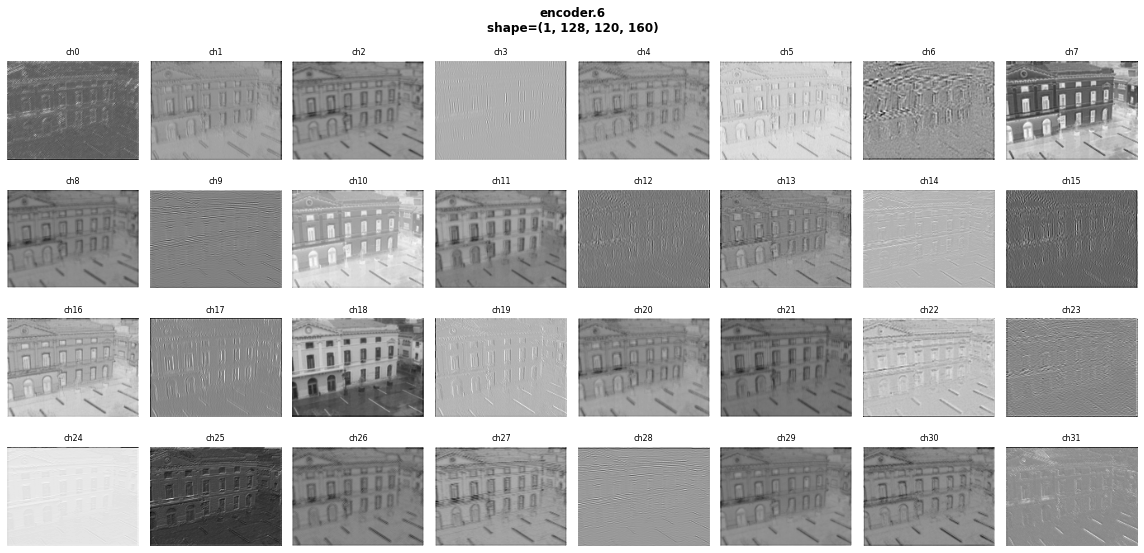


DECODER CONV OUTPUTS


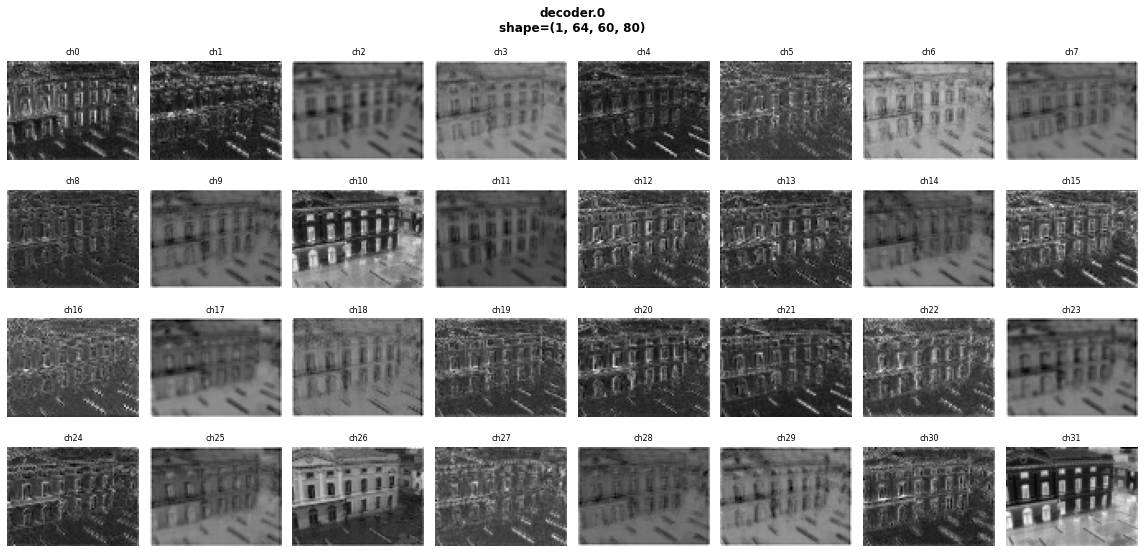

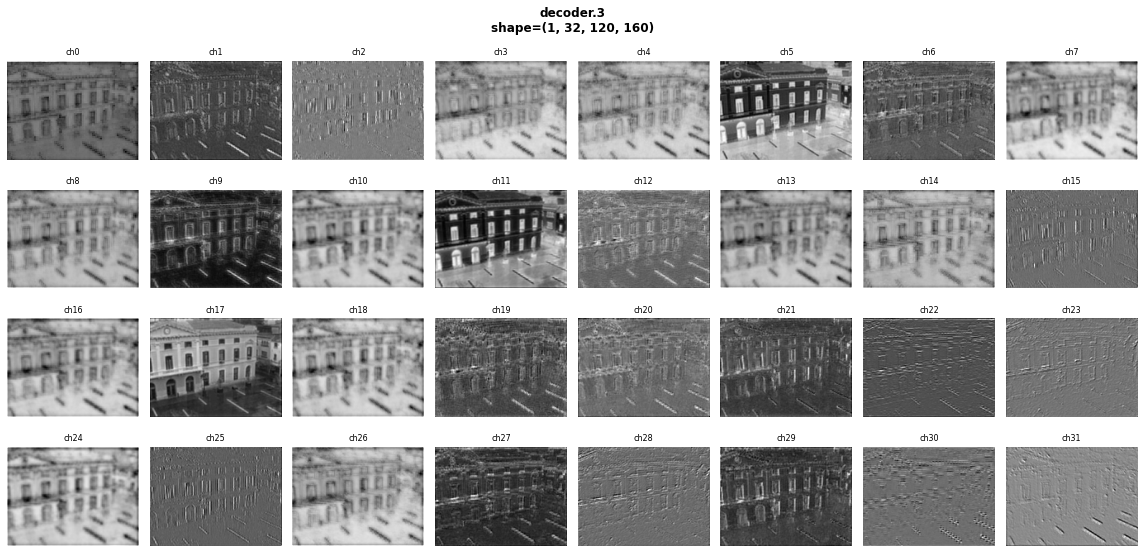

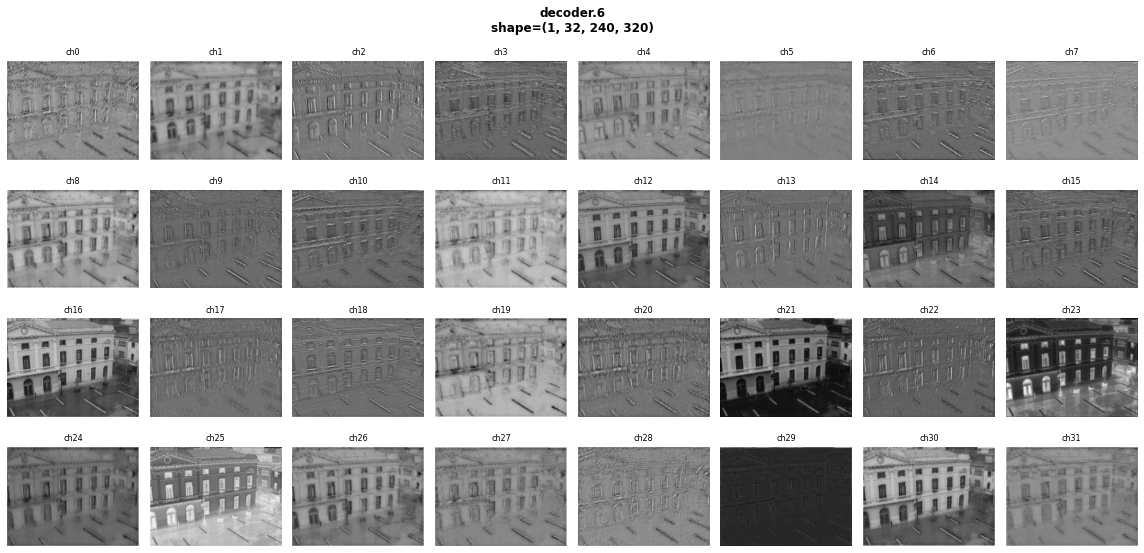

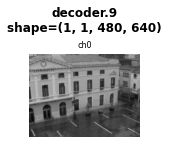

In [6]:
import collections
import torch
import matplotlib.pyplot as plt
import numpy as np

# すべてのConv層の出力を可視化する
# 前提: model, image_tensor, config, image_path が既存セルで定義済み

# 出力を保持する順序付き辞書
conv_outputs = collections.OrderedDict()

# フックを登録
handles = []
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        handles.append(
            module.register_forward_hook(
                lambda model, input, output, layer_name=name: conv_outputs.setdefault(layer_name, output.detach().cpu())
            )
        )

# 推論を実行してConv出力を収集
with torch.no_grad():
    _ = model(image_tensor)

# フックを解除
for h in handles:
    h.remove()


def plot_feature_maps(feat: torch.Tensor, title: str, max_maps: int = 32, cmap: str = "gray"):
    """バッチ先頭の特徴マップを可視化（最大 max_maps チャンネル）。"""
    b, c, h, w = feat.shape
    n = min(c, max_maps)
    cols = min(8, n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.0, rows * 2.0))
    fig.suptitle(f"{title}\nshape={tuple(feat.shape)}", fontsize=12, fontweight="bold")

    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(rows, cols)

    for i in range(n):
        r, cidx = divmod(i, cols)
        ax = axes[r, cidx]
        fm = feat[0, i].float()
        # min-max 正規化して表示
        fm_min, fm_max = fm.min().item(), fm.max().item()
        if fm_max > fm_min:
            fm = (fm - fm_min) / (fm_max - fm_min)
        ax.imshow(fm.numpy(), cmap=cmap)
        ax.set_title(f"ch{i}", fontsize=8)
        ax.axis("off")

    # 余白セルを削除
    for i in range(n, rows * cols):
        r, cidx = divmod(i, cols)
        fig.delaxes(axes[r, cidx])

    plt.tight_layout()
    plt.show()


# 可視化: Encoder / Decoder を分けて表示
print("\n" + "=" * 80)
print("ENCODER CONV OUTPUTS")
print("=" * 80)
for name, feat in conv_outputs.items():
    if name.startswith("encoder"):
        plot_feature_maps(feat, title=name)

print("\n" + "=" * 80)
print("DECODER CONV OUTPUTS")
print("=" * 80)
for name, feat in conv_outputs.items():
    if name.startswith("decoder"):
        plot_feature_maps(feat, title=name)
